<a href="https://colab.research.google.com/github/ivangarrote/Entrega-Equipo-12/blob/main/Entrega3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Dataset1.xlsx to Dataset1.xlsx
Best parameters found by GridSearch: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'n_estimators': 200}
Precisión en el conjunto de prueba: 0.927
F1 Score (weighted): 0.925
              precision    recall  f1-score   support

        Away       0.92      0.97      0.94       156
        Draw       0.94      0.78      0.85       128
        Home       0.93      0.99      0.96       184

    accuracy                           0.93       468
   macro avg       0.93      0.91      0.92       468
weighted avg       0.93      0.93      0.93       468

Probabilidades:
Visita: 0.24
Empate: 0.40
Local: 0.36


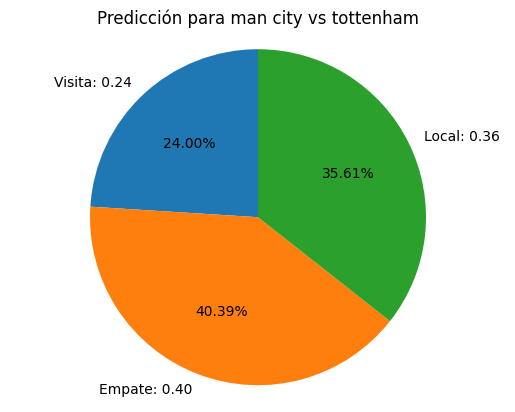

Predicción del ganador: Empate


'Empate'

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import unicodedata
from google.colab import files

# Carga de datos
uploaded = files.upload()
data = pd.read_excel('Dataset1.xlsx')

# Normalización de nombres de equipos
def normalize_team_name(name):
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')
    return name.strip().lower()

data['HomeTeam'] = data['HomeTeam'].apply(normalize_team_name)
data['AwayTeam'] = data['AwayTeam'].apply(normalize_team_name)

# Agregar atributos de rendimiento para cada equipo
def add_team_performance_features(data):
    data['HomeWinRate'] = data.groupby('HomeTeam')['FTR'].transform(lambda x: (x == 'H').mean())
    data['AwayWinRate'] = data.groupby('AwayTeam')['FTR'].transform(lambda x: (x == 'A').mean())
    return data

data = add_team_performance_features(data)

# Crear copia del dataset original
original_data = data.copy()

# Codificar variables categóricas
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam'], prefix=['Home', 'Away'])

# Crear columna 'categorical_FTR'
data['categorical_FTR'] = data['FTR'].map({'H': 2, 'D': 1, 'A': 0})

# Seleccionar columnas de interés
columns_name = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'HomeWinRate', 'AwayWinRate']
columns_name.extend([col for col in data.columns if col.startswith(('Home_', 'Away_'))])

X_all = data[columns_name]
y_all = data['categorical_FTR']

# Escalado de características
scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all, test_size=0.3, random_state=4)

# Ajuste de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2, 2: 1}]
}

rf_model = RandomForestClassifier(random_state=4)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Resultados de GridSearch
print("Best parameters found by GridSearch:", grid_search.best_params_)

# Validación cruzada para obtener probabilidades
y_pred_cv = cross_val_predict(best_rf_model, X_train, y_train, cv=5, method='predict_proba')

# Entrenamiento del mejor modelo con el conjunto de entrenamiento
best_rf_model.fit(X_train, y_train)

# Evaluación del modelo en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print('Precisión en el conjunto de prueba:', round(test_accuracy, 3))
print('F1 Score (weighted):', round(f1_weighted, 3))
print(classification_report(y_test, y_pred, target_names=['Away', 'Draw', 'Home']))

# Función para hacer predicciones de partidos específicos
def predict_match_result(home_team, away_team, data, model, scaler, original_data):
    # Normalizar nombres de equipos ingresados
    home_team = normalize_team_name(home_team)
    away_team = normalize_team_name(away_team)

    # Verificar si los nombres normalizados existen en el conjunto original de equipos
    if home_team not in original_data['HomeTeam'].unique():
        print(f"No se encontró el equipo {home_team} en el conjunto de datos.")
        return None
    if away_team not in original_data['AwayTeam'].unique():
        print(f"No se encontró el equipo {away_team} en el conjunto de datos.")
        return None

    # Obtener las columnas dummies correspondientes
    home_team_columns = [col for col in original_data.columns if col.startswith('Home_')]
    away_team_columns = [col for col in original_data.columns if col.startswith('Away_')]

    # Obtener HomeWinRate y AwayWinRate para los equipos
    home_win_rate = original_data[original_data['HomeTeam'] == home_team]['HomeWinRate'].values[0]
    away_win_rate = original_data[original_data['AwayTeam'] == away_team]['AwayWinRate'].values[0]

    # Crear DataFrame con todos los valores en 0
    X_example = pd.DataFrame(0, index=[0], columns=columns_name)

    # Asignar 1 a las columnas correspondientes
    home_team_column = f'Home_{home_team}'
    away_team_column = f'Away_{away_team}'
    if home_team_column in X_example.columns:
        X_example[home_team_column] = 1
    if away_team_column in X_example.columns:
        X_example[away_team_column] = 1

    # Asignar HomeWinRate y AwayWinRate
    X_example['HomeWinRate'] = home_win_rate
    X_example['AwayWinRate'] = away_win_rate

    # Escalar los datos de ejemplo
    X_example_scaled = scaler.transform(X_example)

    # Predecir probabilidades
    pred_probs = model.predict_proba(X_example_scaled)[0]

    # Mostrar las probabilidades
    pie_labels = ['Visita', 'Empate', 'Local']
    print("Probabilidades:")
    for label, prob in zip(pie_labels, pred_probs):
        print(f"{label}: {prob:.2f}")

    # Gráfico de las probabilidades
    pie_labels = [f"{label}: {prob:.2f}" for label, prob in zip(pie_labels, pred_probs)]
    plt.figure()
    plt.pie(pred_probs, labels=pie_labels, autopct='%1.2f%%', startangle=90)
    plt.axis('equal')
    plt.title(f"Predicción para {home_team} vs {away_team}")
    plt.show()

    # Mostrar el resultado de la predicción
    predicted_outcome = pie_labels[np.argmax(pred_probs)].split(":")[0]
    print('Predicción del ganador:', predicted_outcome)
    return predicted_outcome

# Ejemplo de uso para predicción específica
predict_match_result(home_team='Man City', away_team='Tottenham', data=data, model=best_rf_model, scaler=scaler, original_data=original_data)
